<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/PCam_Final_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Data is a modified version of the PCam dataset--duplicates have been removed. The goal is to classify the images as cancerous or non-cancerous. A positive label indicates that the center 32x32 pixel region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
https://www.kaggle.com/c/histopathologic-cancer-detection/data?select=train_labels.csv 

###Acknowledgements
Code was adapted from the following sources:

Deep Learning with Python by Francis Chollet

https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch


#Setup and Preprocessing

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set(style="whitegrid")

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import os, random
from random import shuffle
import cv2 #image processing
from glob import glob #for easily finding matching filenames 
from tqdm import tqdm, tqdm_notebook, trange #progress bar
import gc #garbage collection, for saving RAM

import tensorflow as tf
from tensorflow import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0-tf'

In [2]:
from keras import metrics
from keras import models
from keras import layers

Using TensorFlow backend.


##Upload data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Code executed once to unzip the files, then commented out:

In [ ]:
# #unzip set of training files (smaller dataset to make sure it works)
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/sampleTrain.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain"

In [4]:
#Check whether sample files are readable
sample_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain/sampleTrain')
print(f'{len(sample_names)} files in sample directory')
print(sample_names[:5])

10 files in sample directory
['00a0ad1de2cdf805f02c524a985bca5bce1d1b5f.tif', '0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif', '0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif', '0a0d1a09e5cf9fcc308ecdc210450aecd204d344.tif', '0a0b4604d66cecfe668e26383c22fafb74484eef.tif']


Started with 10,000 and then 80,000 training files in order develop models.

Be sure to change path below when adding more files.

In [5]:
#unzip set of training files
!unzip -uq "/content/drive/My Drive/MSDS 458/PCam/train110P.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/train"

In [6]:
# drive.mount("/content/drive", force_remount=True)

In [7]:
#Check whether sample files are readable
train_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/train/train110P')
print(f'{len(train_names)} files in training directory')
print(train_names[:5])

110001 files in training directory
['99ef485f205645918613cd04281098daa7c17819.tif', '6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif', '9c043ab2adadfeb758c71d21432fccd3e43565c0.tif', '9cc775713dd09351172a350871a547346af08027.tif', '1996c210f020134e986823ca7d4df0a70a799c34.tif']


Code below to unzip testing data. It has not been run yet it order to save space on Drive.

In [ ]:
# #unzip set of testing files 
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/test.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/test"

In [ ]:
# #Check whether sample files are readable
# test_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/test')
# print(f'{len(test_names)} files in testing directory')
# print(test_names[:5])

##Set paths

In [8]:
path = '/content/drive/My Drive/MSDS 458/PCam/unzipped/'
train_path = path+'train/train110P'
test_path =  path+'test/'
sample_path = path+'sampleTrain/sampleTrain'  #contains 10 images, simply for testing that data can be read
IMG_SIZE = 40

##Load labels and filenames

In [9]:
labels = pd.read_csv('/content/drive/My Drive/MSDS 458/PCam/train_labels.csv')

In [10]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[9].split(".")[0]) # keep only the file names in 'id'
df.head()

,path,id
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,99ef485f205645918613cd04281098daa7c17819
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9c043ab2adadfeb758c71d21432fccd3e43565c0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9cc775713dd09351172a350871a547346af08027
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,1996c210f020134e986823ca7d4df0a70a799c34


In [11]:
df = df.merge(labels, on = "id") # merge labels and filepaths

In [12]:
df.head(5) # print the first five entries

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,99ef485f205645918613cd04281098daa7c17819,1
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9cc775713dd09351172a350871a547346af08027,0
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,1996c210f020134e986823ca7d4df0a70a799c34,1


In [13]:
print(df.count) #check total number of rows in dataframe

<bound method DataFrame.count of                                                      path  ... label
0       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
1       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
2       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
3       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
4       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
...                                                   ...  ...   ...
109995  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
109996  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
109997  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
109998  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
109999  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0

[110000 rows x 3 columns]>


In [14]:
# look at distribution of the data
df['label'].value_counts()

0    65505
1    44495
Name: label, dtype: int64

##Load images

In [15]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,IMG_SIZE,IMG_SIZE,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    dfLabel=df['label']
    y = np.squeeze(dfLabel.to_numpy())[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    # Scale the data to [0,1] interval
    X = X.astype('float16')/255      #comment out to perform EDA steps
    return X,y

In [16]:
# Load some of the images
N=100
X,y = load_data(N=N,df=df) #this is from dataframe that is not uniformly distributed, but is shuffled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


##Balancing out classes, since 40% are in class 1

Ended up using 60:40 ratio in final models in order to retain larger number of training images. Non-cancerous images are also more common in the field.

In [ ]:
# create dataframe with all of the class 1 samples
df_1 = df[df['label']==1]
sample_size = len(df_1)
sample_size

44495

In [ ]:
# take a random sample of class 0 that is equal to the number of samples in class 1
df_0 = df[df['label']==0].sample(sample_size, random_state = 42)

In [ ]:
# concatenate the dataframes
df_equal = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_equal['label'].value_counts()

1    44495
0    44495
Name: label, dtype: int64

In [ ]:
df_equal.head()

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,030d7c22a9b64d942e848351853cc111e27c47bc,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,320bb1705c916b8f4610f2f01a19abe2d968dddb,0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6b2f970df170b3c79cdf26d2035e9f3e507c05b9,0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,3cd6daa2c37d8060c6c5677356c25272023ea603,0
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,40a742a97406af97326423b68d3e9ad76b459f79,0


##EDA

View some sample images. Non-cancerous samples are labeled 0, and cancerous samples are labeled 1.

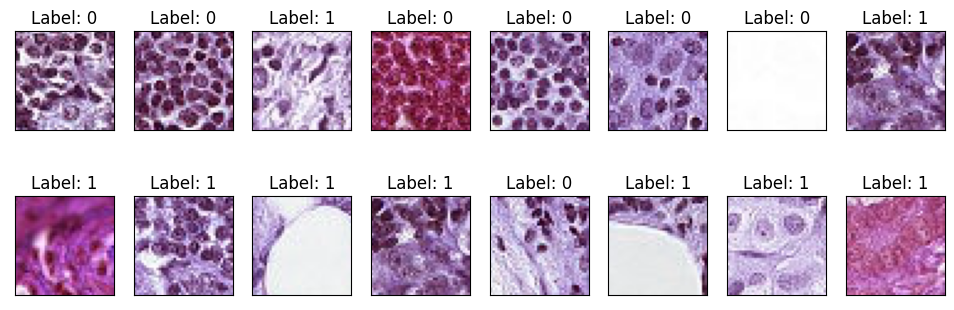

In [ ]:
fig = plt.figure(figsize=(12, 4), dpi=100)
np.random.seed(777) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,16)):
    ax = fig.add_subplot(2, 16//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

Evaluate the distribution of the two classes in the full dataset

Text(0, 0.5, 'Samples')

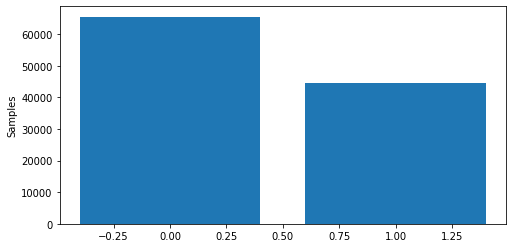

In [ ]:
plt.figure(figsize=[8,4])
plt.bar([0,1], [(df['label']==0).sum(), (df['label']==1).sum()])
plt.axis()
plt.xticks([0,1],[f"Negative (N={df['label']==0.sum()})",f"Positive (N={df['label']==1.sum()})"],rotation=45)
#plt.xticks(rotation=45)
#plt.rc('xtick',labelsize=10)
plt.ylabel('Samples')


In [ ]:
print(f"{round((df['label']==1).sum()/len(df)*100,2)}% of the samples are positive.") 
print(f"We need to clear the baseline of {round((df['label']==0).sum()/len(df)*100,2)}%, which would be the accuracy if we predicted that all of the samples were non-cancerous.")

40.45% of the samples are positive.
We need to clear the baseline of 59.55%, which would be the accuracy if we predicted that all of the samples were non-cancerous.


###To evaluate the classes individually

In [ ]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

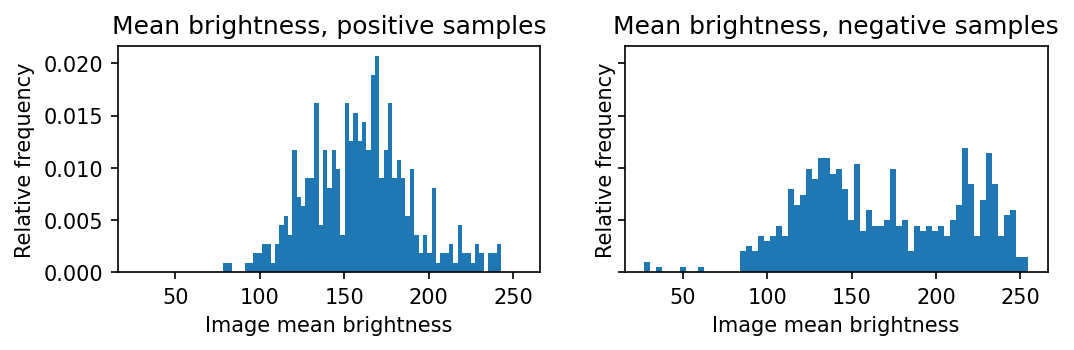

In [ ]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

In [ ]:
#Clean up variables to free up RAM
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

#Prepare data for modeling

In [17]:
#Load remainder of dataset
X_ = None
y = None
gc.collect();
#using df with same number of samples per class
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [18]:
X[1]

array([[[0.792 , 0.498 , 0.8276],
        [0.7607, 0.451 , 0.792 ],
        [0.7607, 0.4314, 0.7803],
        ...,
        [0.7256, 0.3608, 0.6943],
        [0.7764, 0.4   , 0.678 ],
        [0.757 , 0.3765, 0.6274]],

       [[0.655 , 0.349 , 0.6943],
        [0.745 , 0.4392, 0.7803],
        [0.9253, 0.608 , 0.949 ],
        ...,
        [0.651 , 0.3137, 0.643 ],
        [0.6626, 0.302 , 0.5884],
        [0.7803, 0.392 , 0.6587]],

       [[0.753 , 0.4314, 0.8037],
        [0.9097, 0.596 , 0.953 ],
        [0.7334, 0.4119, 0.7607],
        ...,
        [0.855 , 0.5293, 0.863 ],
        [0.714 , 0.357 , 0.651 ],
        [0.678 , 0.2903, 0.565 ]],

       ...,

       [[0.8667, 0.5728, 0.8394],
        [0.7256, 0.396 , 0.647 ],
        [0.4236, 0.0706, 0.306 ],
        ...,
        [0.859 , 0.5215, 0.7725],
        [0.718 , 0.3687, 0.639 ],
        [0.702 , 0.341 , 0.6196]],

       [[1.    , 0.8394, 1.    ],
        [1.    , 0.749 , 0.9805],
        [0.7295, 0.4824, 0.678 ],
        .

##Train test split

In [19]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
#not setting a random_state and not shuffling because samples are already shuffled and want to save RAM 
# added random state instead of shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((88000, 40, 40, 3), (22000, 40, 40, 3), (88000,), (22000,))

In [21]:
# X = None
# y = None
# gc.collect();

#Define callbacks for training/testing times

In [22]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [23]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

#Experiment 1:DNN
Establish a baseline with a simple two layer DNN.

First hidden layer has 200 nodes, second hidden layer has 100 nodes.

##Build and compile the model

In [24]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               960200    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 980,401
Trainable params: 980,401
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [26]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 74800 samples, validate on 13200 samples
Epoch 1/15
74800/74800 [==============================] - 7s 93us/step - loss: 0.6570 - accuracy: 0.5960 - val_loss: 0.6215 - val_accuracy: 0.6402
Epoch 2/15
74800/74800 [==============================] - 5s 68us/step - loss: 0.6299 - accuracy: 0.6191 - val_loss: 0.6147 - val_accuracy: 0.6440
Epoch 3/15
74800/74800 [==============================] - 5s 69us/step - loss: 0.6215 - accuracy: 0.6362 - val_loss: 0.5995 - val_accuracy: 0.6517
Epoch 4/15
74800/74800 [==============================] - 5s 70us/step - loss: 0.6141 - accuracy: 0.6494 - val_loss: 0.6378 - val_accuracy: 0.6977
Epoch 5/15
74800/74800 [==============================] - 5s 69us/step - loss: 0.5996 - accuracy: 0.6715 - val_loss: 0.5740 - val_accuracy: 0.7092
Epoch 6/15
74800/74800 [==============================] - 5s 72us/step - loss: 0.5915 - accuracy: 0.6825 - val_loss: 0.5711 - val_accuracy: 0.6911
Epoch 7/15
74800/74800 [==============================] - 5s 70us/st

In [27]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

79.5649

##Test the model

In [28]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

22000/22000 [==============================] - 2s 79us/step


(0.5415509409037503, 0.7365909218788147)

In [29]:
test_time = test_rt.process_time
test_time # in seconds

1.732553

###ROC and AUROC

In [30]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [31]:
auc_keras = auc(fpr, tpr)

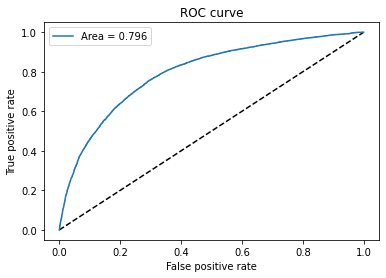

In [32]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Create a dataframe for the training and test statistics

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [34]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,val_loss,val_accuracy,loss,accuracy
10,0.553921,0.708561,0.560597,0.710441
11,0.554427,0.723106,0.557171,0.712754
12,0.543274,0.727803,0.555558,0.716484
13,0.557388,0.711591,0.552506,0.718249
14,0.545215,0.734091,0.547411,0.719452


In [35]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layer)') 
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['auroc'] = auc_keras
results_df['train time'] = train_time    
results_df['test time'] = test_time    
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,DNN (2 layer),0.545215,0.734091,0.547411,0.719452,0.541551,0.736591,0.795994,79.5649,1.732553


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

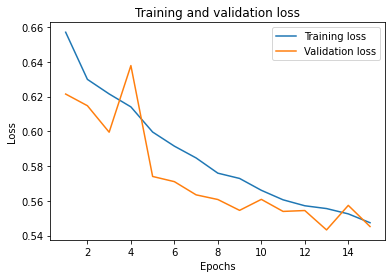

In [36]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

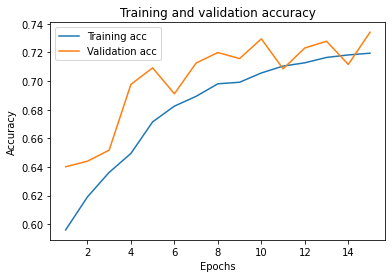

In [37]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###Confusion matrix
True (row) and predicted (column) values

In [38]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [39]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[43151,  9166],
       [13750, 21933]])

#Experiment 3: CNN with 2 convolutional layers, fully trained on PCam dataset.

First hidden layer has 32 nodes, second hidden layer has 64 nodes.

In [194]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)             

In [195]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [196]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=20,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 74800 samples, validate on 13200 samples
Epoch 1/20
74800/74800 [==============================] - 7s 95us/step - loss: 0.6593 - accuracy: 0.5954 - val_loss: 0.6022 - val_accuracy: 0.7544
Epoch 2/20
74800/74800 [==============================] - 7s 91us/step - loss: 0.5175 - accuracy: 0.7558 - val_loss: 0.5131 - val_accuracy: 0.7620
Epoch 3/20
74800/74800 [==============================] - 7s 91us/step - loss: 0.4942 - accuracy: 0.7709 - val_loss: 0.4882 - val_accuracy: 0.7717
Epoch 4/20
74800/74800 [==============================] - 7s 90us/step - loss: 0.4849 - accuracy: 0.7754 - val_loss: 0.4968 - val_accuracy: 0.7698
Epoch 5/20
74800/74800 [==============================] - 7s 91us/step - loss: 0.4766 - accuracy: 0.7806 - val_loss: 0.4810 - val_accuracy: 0.7820
Epoch 6/20
74800/74800 [==============================] - 7s 90us/step - loss: 0.4667 - accuracy: 0.7864 - val_loss: 0.4527 - val_accuracy: 0.7928
Epoch 7/20
74800/74800 [==============================] - 7s 90us/st

In [197]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

135.790261

##Test the model

In [198]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

22000/22000 [==============================] - 2s 101us/step


(0.40383970776471223, 0.8217727541923523)

In [199]:
test_time = test_rt.process_time
test_time # in seconds

2.232712

###ROC and AUROC

In [200]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [201]:
auc_keras = auc(fpr, tpr)

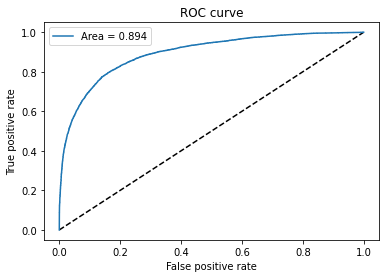

In [202]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [203]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layer)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
19,CNN (2 layer),0.405068,0.823636,0.394267,0.827313,0.40384,0.821773,0.893829,135.790261,2.232712


In [204]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (2 layer),0.545215,0.734091,0.547411,0.719452,0.541551,0.736591,0.795994,79.564900,1.732553
1,CNN (2 layer),0.405068,0.823636,0.394267,0.827313,0.403840,0.821773,0.893829,135.790261,2.232712


### Plotting the performance 


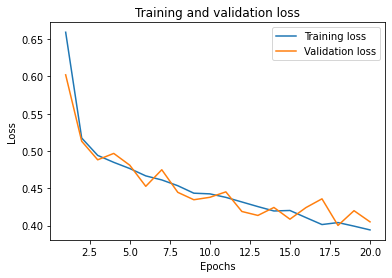

In [205]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

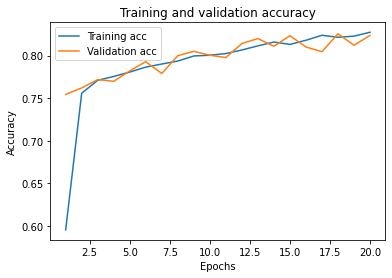

In [206]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Based on these graphs, the model still isn't overfitting and looks like it could benefit from some added complexity.

###Confusion matrix
True (row) and predicted (column) values

In [207]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [208]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[44065,  8252],
       [ 7058, 28625]])

#Feature Extraction

In [209]:
train_names[0]

'99ef485f205645918613cd04281098daa7c17819.tif'

In [210]:
# map sample image to array
img_path = train_path + '/' + train_names[0]

from keras.preprocessing import image                             

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                                
print(img_tensor.shape)  

(1, 40, 40, 3)


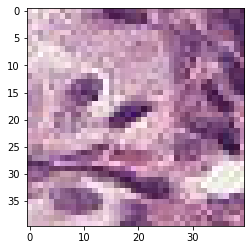

In [211]:
# display sample image
plt.imshow(img_tensor[0])
plt.show()

In [212]:
# instantiate a model from an input tensor and list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [213]:
activations = activation_model.predict(img_tensor)

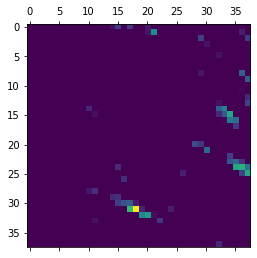

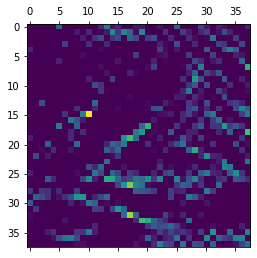

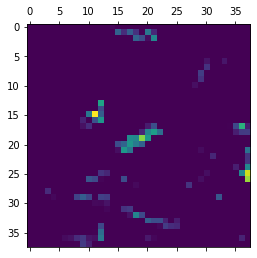

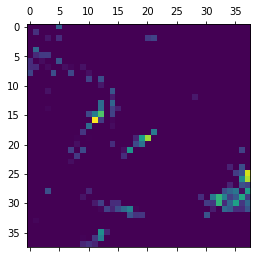

In [214]:
# activation of the first convolution layer for the sample image input
first_layer_activation = activations[0]

for x in range(4):
  plt.matshow(first_layer_activation[0, :, :, x], cmap='viridis')

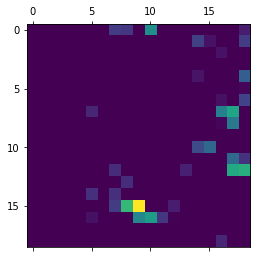

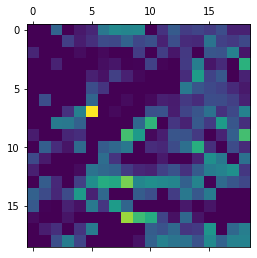

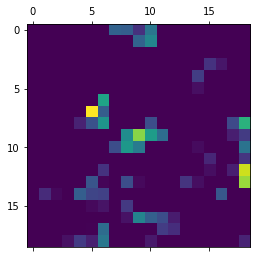

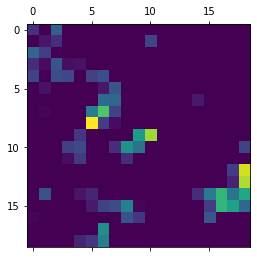

In [215]:
# activation of the second convolution layer for the sample image input
second_layer_activation = activations[1]

for x in range(4):
  plt.matshow(second_layer_activation[0, :, :, x], cmap='viridis')

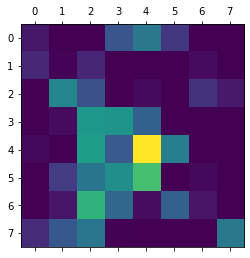

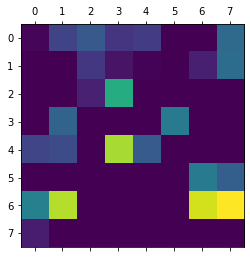

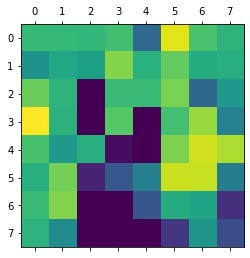

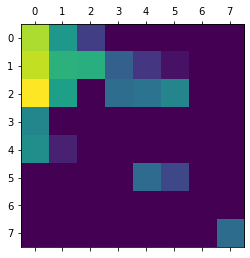

In [216]:
# activation of the fifth convolution layer for the sample image input
fifth_layer_activation = activations[4]

for x in range(4):
  plt.matshow(fifth_layer_activation[0, :, :, x], cmap='viridis')

Note that the features activated in the higher levels are more abstract than those in the lowest level. The lower levels encode visual information such as edges and shades. The higher levels encode whether or not key attributes of cancerous images are present in the sample.

#Pre-trained Network: VGG16

In [217]:
from keras.applications import VGG16

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5)

VGG16 was originally trained on ImageNet. We freeze the lower layers that have already learned basic visual features from that large corpus of data. We will now train the final six convolutional layers on the PCam data so that the model learns abstract features specific to this dataset.

Instantiate model

In [218]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (IMG_SIZE, IMG_SIZE, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [219]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [220]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [221]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 74800 samples, validate on 13200 samples
Epoch 1/15
74800/74800 [==============================] - 37s 494us/step - loss: 0.5947 - accuracy: 0.7114 - val_loss: 0.4473 - val_accuracy: 0.7933
Epoch 2/15
74800/74800 [==============================] - 37s 490us/step - loss: 0.4373 - accuracy: 0.8014 - val_loss: 0.4184 - val_accuracy: 0.8098
Epoch 3/15
74800/74800 [==============================] - 37s 495us/step - loss: 0.4099 - accuracy: 0.8155 - val_loss: 0.3916 - val_accuracy: 0.8258
Epoch 4/15
74800/74800 [==============================] - 37s 493us/step - loss: 0.3922 - accuracy: 0.8252 - val_loss: 0.3831 - val_accuracy: 0.8283
Epoch 5/15
74800/74800 [==============================] - 37s 494us/step - loss: 0.3829 - accuracy: 0.8316 - val_loss: 0.3794 - val_accuracy: 0.8344
Epoch 6/15
74800/74800 [==============================] - 37s 494us/step - loss: 0.3736 - accuracy: 0.8345 - val_loss: 0.3710 - val_accuracy: 0.8392
Epoch 7/15
74800/74800 [==============================] 

In [222]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

553.768467

###Test the model

In [223]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

22000/22000 [==============================] - 11s 483us/step


(0.3764376316070557, 0.8428182005882263)

In [224]:
test_time = test_rt.process_time
test_time # in seconds

10.62356

###ROC and AUROC

In [225]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [226]:
auc_keras = auc(fpr, tpr)

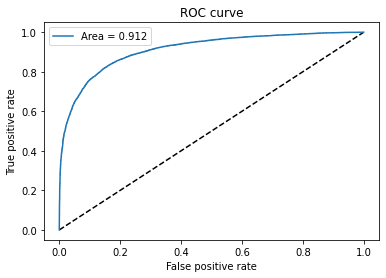

In [227]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [228]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16 (6 unfrozen)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,VGG16 (6 unfrozen),0.373698,0.841742,0.287802,0.879184,0.376438,0.842818,0.911925,553.768467,10.62356


In [229]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (2 layer),0.545215,0.734091,0.547411,0.719452,0.541551,0.736591,0.795994,79.564900,1.732553
1,CNN (2 layer),0.405068,0.823636,0.394267,0.827313,0.403840,0.821773,0.893829,135.790261,2.232712
2,VGG16 (6 unfrozen),0.373698,0.841742,0.287802,0.879184,0.376438,0.842818,0.911925,553.768467,10.623560


### Plotting the performance 


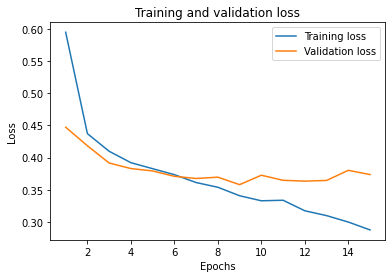

In [230]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

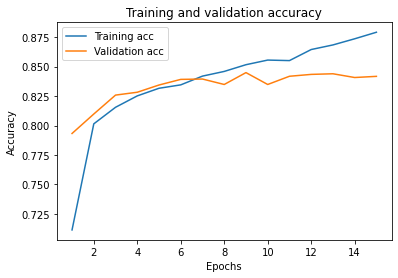

In [231]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###Confusion matrix
True (row) and predicted (column) values

In [232]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [233]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[48486,  3831],
       [ 6142, 29541]])

The pre-trained network significantly outperforms the CNN that was trained "from scratch" on the PCam data. It benefits from the lower level features that were learned from the millions of samples in ImageNet.

#Export results

In [235]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam110k_finalModels.csv')
files.download('PCam110k_finalModels.csv')